In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
from monty.serialization import dumpfn, loadfn
from collections import defaultdict

In [3]:
from ase.filters import FrechetCellFilter
from fairchem.core import pretrained_mlip, FAIRChemCalculator
from ase.optimize import LBFGS
from pymatgen.io.ase import AseAtomsAdaptor

predictor = pretrained_mlip.get_predict_unit("uma-m-1p1", device="cuda")
calc = FAIRChemCalculator(predictor, task_name="omat") # use "omat" - inorganic materials

In [4]:
def relaxation_defect(structure): # takes in pymatgen structure
    atoms = structure.to_ase_atoms()
    atoms.calc = calc

    opt = LBFGS(atoms) # Delete this FrechetCellFilter when doing the defect structures
    opt.run(0.01, 1000)

    structure1 = AseAtomsAdaptor.get_structure(atoms)
    energy = atoms.get_potential_energy()

    return structure1, energy 

Load in all relaxed primitive Al Oxide structures
<br>Loop through all Al oxides 
<br>Create function using doped and shakenbreak for each structure
<br>Create function that loops over unpertubed and all disortions and uses MLIP to calc energies - append structure and energies to data dict
<br>get energy difference from unperturbed for each Al oxide and append to dictionary or list for bar chart - can do this manually in loop 
<br>dumpfn the data dict and list of energy differences, or maybe add energy diff to data dict as 'delta_e' key?
<br>Plot bar chart for all metal oxides and their energy relative to unperturbed

In [5]:
from doped.generation import DefectsGenerator
from shakenbreak.input import Distortions

In [6]:
def create_defect(structure):
    defect_gen = DefectsGenerator(structure, extrinsic="Cr", interstitial_gen_kwargs=False) # set large super cell 25 Angstroms 'supercell_gen_kwargs={'min_image_distance':15}'
    valid_keys = []
    for key in defect_gen.keys():
        if  key[:5] == 'Cr_Al' and key[-1] == '0':
            valid_keys.append(key)
    Dist = Distortions(
        defect_entries = {key: defect_gen[key] for key in valid_keys}, # NO Cr_Al_0 for Al2(SO4)3
        # oxidation_states={} # oxidation states predicted are good for now
    )
    distorted_defects_dict, Dist.distortion_metadata = Dist.apply_distortions()
    unperturbed_structures = {}
    distortions = {}
    for key in valid_keys:
        unperturbed_structures[key] = distorted_defects_dict[key[:-2]]['charges'][0]['structures']['Unperturbed']
        distortions[key] = distorted_defects_dict[key[:-2]]['charges'][0]['structures']['distortions']

    return dict(unperturbed_structures), dict(distortions), defect_gen.bulk_supercell

In [7]:
def get_energy(unperturbed_structures, distortions, supercell):
    data = defaultdict(dict)
    supercell_struct, supercell_e = relaxation_defect(supercell)
    data['supercell'] = {
        'structure': supercell_struct,
        'energy': supercell_e
    }
    
    for site, unperturbed_structure in unperturbed_structures.items():
        data[site] = defaultdict(dict)
        data[site]['unperturbed'] = defaultdict(dict)
        unperturbed_structure1, unp_energy = relaxation_defect(unperturbed_structure)
        data[site]['unperturbed'] = {
        'structure':unperturbed_structure1,
        'energy': unp_energy,
        'distortion_amount':'N/A'
        }
        data[site]['distortions'] = defaultdict(dict)
        for key, structure in distortions[site].items():
            structure1, energy = relaxation_defect(structure)
            if key != 'Rattled':
                distortion_amount = float(key.split("_")[-1].replace("%", "").replace("-", "-"))/100
            else:
                distortion_amount = 0
            data[site]['distortions'][key] = {
                'structure': structure1,
                'energy': energy,
                'distortion_amount': distortion_amount,
                'delta_e': energy - unp_energy
            }
    
    return dict(data)

In [8]:
Al_prim = loadfn('../data/relaxed_Al_prim.json')
del Al_prim['mp-554152']

In [9]:
data = {}
for key, val in Al_prim.items():
    unperturbed_structures, distortions, supercell = create_defect(val['structure'])
    mini_data = get_energy(unperturbed_structures, distortions, supercell) # add in host supercell relaxation
    data[key] = mini_data


Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [01:19,   1.26it/s]


Vacancies                 Guessed Charges        Conv. Cell Coords    Wyckoff
------------------------  ---------------------  -------------------  ---------
v_Al                      [+1,0,-1,-2,-3]        [0.116,0.637,0.375]  4e
v_P_C1_O1.49              [+1,0,-1,-2,-3,-4,-5]  [0.203,0.664,0.016]  4e
v_P_C1_O1.50O1.60         [+1,0,-1,-2,-3,-4,-5]  [0.145,0.544,0.718]  4e
v_P_C1_O1.50O1.61         [+1,0,-1,-2,-3,-4,-5]  [0.415,0.112,0.213]  4e
v_O_C1_P1.49              [+2,+1,0,-1]           [0.822,0.257,0.090]  4e
v_O_C1_P1.50Al1.90O2.52   [+2,+1,0,-1]           [0.194,0.158,0.148]  4e
v_O_C1_P1.50Al1.90O2.53a  [+2,+1,0,-1]           [0.576,0.114,0.107]  4e
v_O_C1_P1.50Al1.90O2.53b  [+2,+1,0,-1]           [0.165,0.619,0.608]  4e
v_O_C1_P1.50Al1.91        [+2,+1,0,-1]           [0.068,0.655,0.141]  4e
v_O_C1_P1.50Al1.92        [+2,+1,0,-1]           [0.055,0.515,0.335]  4e
v_O_C1_P1.60              [+2,+1,0,-1]           [0.853,0.421,0.100]  4e
v_O_C1_P1.61              [+2,+1,0,-1] 

Generating distorted defect structures...0.0%|                                                            | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   4.60it/s]


       Step     Time          Energy          fmax
LBFGS:    0 16:32:05    -1143.208343        0.007806
       Step     Time          Energy          fmax
LBFGS:    0 16:32:10    -1143.583089        1.963626
LBFGS:    1 16:32:15    -1143.738302        1.310549
LBFGS:    2 16:32:19    -1143.871816        0.596801
LBFGS:    3 16:32:24    -1143.919652        0.378782
LBFGS:    4 16:32:29    -1143.947652        0.303747
LBFGS:    5 16:32:34    -1143.967885        0.176548
LBFGS:    6 16:32:39    -1143.978887        0.213258
LBFGS:    7 16:32:44    -1143.989034        0.194240
LBFGS:    8 16:32:49    -1143.996328        0.099969
LBFGS:    9 16:32:54    -1144.000097        0.103250
LBFGS:   10 16:32:59    -1144.002416        0.068624
LBFGS:   11 16:33:04    -1144.004339        0.079791
LBFGS:   12 16:33:08    -1144.005819        0.065221
LBFGS:   13 16:33:13    -1144.007238        0.053522
LBFGS:   14 16:33:18    -1144.008581        0.055531
LBFGS:   15 16:33:23    -1144.009695        0.0627

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:24,   4.00it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Li         [+1,0,-1]          [0.000,0.000,0.000]  3a
v_Al         [+1,0,-1,-2,-3]    [0.000,0.000,0.500]  3b
v_O          [+2,+1,0,-1]       [0.000,0.000,0.238]  6c

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Li_Al            [0,-1,-2]           [0.000,0.000,0.500]  3b
Li_O             [+3,+2,+1,0]        [0.000,0.000,0.238]  6c
Al_Li            [+2,+1,0]           [0.000,0.000,0.000]  3a
Al_O             [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.238]  6c
O_Li             [0,-1,-2,-3]        [0.000,0.000,0.000]  3a
O_Al             [0,-1,-2,-3,-4,-5]  [0.000,0.000,0.500]  3b
Cr_Li            [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.000]  3a
Cr_Al            [+3,+2,+1,0,-1]     [0.000,0.000,0.500]  3b
Cr_O             [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.238]  6c

The number in the Wycko

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   7.62it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 16:41:10     -688.263262        0.001873
       Step     Time          Energy          fmax
LBFGS:    0 16:41:15     -688.903069        1.693455
LBFGS:    1 16:41:21     -689.100182        1.030940
LBFGS:    2 16:41:27     -689.237084        0.216185
LBFGS:    3 16:41:32     -689.245095        0.138487
LBFGS:    4 16:41:38     -689.250252        0.080500
LBFGS:    5 16:41:44     -689.252907        0.060100
LBFGS:    6 16:41:50     -689.254433        0.048851
LBFGS:    7 16:41:55     -689.255120        0.028122
LBFGS:    8 16:42:01     -689.255455        0.020978
LBFGS:    9 16:42:07     -689.255791        0.018542
LBFGS:   10 16:42:13     -689.256051        0.021001
LBFGS:   11 16:42:19     -689.256295        0.013582
LBFGS:   12 16:42:25     -689.256432        0.011444
LBFGS:   13 16:42:30     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:15,   6.64it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Al         [+1,0,-1,-2,-3]    [0.000,0.500,0.095]  2b
v_Cl         [+1,0,-1]          [0.000,0.000,0.713]  2a
v_O          [+2,+1,0,-1]       [0.000,0.000,0.045]  2a

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Al_Cl            [+4,+3,+2,+1,0]     [0.000,0.000,0.713]  2a
Al_O             [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.045]  2a
Cl_Al            [0,-1,-2,-3,-4]     [0.000,0.500,0.095]  2b
Cl_O             [+1,0]              [0.000,0.000,0.045]  2a
O_Al             [0,-1,-2,-3,-4,-5]  [0.000,0.500,0.095]  2b
O_Cl             [0,-1]              [0.000,0.000,0.713]  2a
Cr_Al            [+3,+2,+1,0,-1]     [0.000,0.500,0.095]  2b
Cr_Cl            [+4,+3,+2,+1,0]     [0.000,0.000,0.713]  2a
Cr_O             [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.045]  2a

The number in the Wycko

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,  16.30it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 16:46:54     -316.789552        0.000616
       Step     Time          Energy          fmax
LBFGS:    0 16:46:55     -317.925487        2.179511
LBFGS:    1 16:46:57     -318.071182        1.064940
LBFGS:    2 16:46:59     -318.148045        0.383009
LBFGS:    3 16:47:01     -318.164131        0.295001
LBFGS:    4 16:47:03     -318.180954        0.185186
LBFGS:    5 16:47:05     -318.186005        0.144772
LBFGS:    6 16:47:07     -318.189522        0.097028
LBFGS:    7 16:47:09     -318.191513        0.097895
LBFGS:    8 16:47:11     -318.193153        0.096802
LBFGS:    9 16:47:13     -318.194084        0.059689
LBFGS:   10 16:47:15     -318.194687        0.050501
LBFGS:   11 16:47:17     -318.195148        0.038322
LBFGS:   12 16:47:19     -318.195557        0.035037
LBFGS:   13 16:47:20     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:22,   4.47it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Sm         [+1,0,-1,-2,-3]    [0.491,0.250,0.464]  4c
v_Al         [+1,0,-1,-2,-3]    [0.000,0.000,0.500]  4b
v_O_C1       [+2,+1,0,-1]       [0.219,0.038,0.218]  8d
v_O_Cs       [+2,+1,0,-1]       [0.572,0.250,0.013]  4c

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Sm_Al            [+1,0,-1]           [0.000,0.000,0.500]  4b
Sm_O_C1          [+5,+4,+3,+2,+1,0]  [0.219,0.038,0.218]  8d
Sm_O_Cs          [+5,+4,+3,+2,+1,0]  [0.572,0.250,0.013]  4c
Al_Sm            [+1,0,-1]           [0.491,0.250,0.464]  4c
Al_O_C1          [+5,+4,+3,+2,+1,0]  [0.219,0.038,0.218]  8d
Al_O_Cs          [+5,+4,+3,+2,+1,0]  [0.572,0.250,0.013]  4c
O_Sm             [0,-1,-2,-3,-4,-5]  [0.491,0.250,0.464]  4c
O_Al             [0,-1,-2,-3,-4,-5]  [0.000,0.000,0.500]  4b
Cr_Sm            [+3,+2,+1,0,

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   6.81it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 16:49:20     -634.784229        0.008151
       Step     Time          Energy          fmax
LBFGS:    0 16:49:24     -635.443948        1.687024
LBFGS:    1 16:49:27     -635.618677        0.923077
LBFGS:    2 16:49:31     -635.708765        0.236172
LBFGS:    3 16:49:34     -635.719431        0.166745
LBFGS:    4 16:49:38     -635.732630        0.131195
LBFGS:    5 16:49:42     -635.736490        0.095735
LBFGS:    6 16:49:45     -635.739847        0.068551
LBFGS:    7 16:49:49     -635.741617        0.049313
LBFGS:    8 16:49:53     -635.743417        0.044873
LBFGS:    9 16:49:57     -635.745020        0.048013
LBFGS:   10 16:50:00     -635.746271        0.042863
LBFGS:   11 16:50:04     -635.746988        0.028761
LBFGS:   12 16:50:08     -635.747400        0.023708
LBFGS:   13 16:50:11     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:24,   4.08it/s]


Vacancies       Guessed Charges        Conv. Cell Coords    Wyckoff
--------------  ---------------------  -------------------  ---------
v_Al            [+1,0,-1,-2,-3]        [0.000,0.000,0.000]  2a
v_W             [+1,0,-1,-2,-3,-4,-5]  [0.000,0.500,0.500]  2c
v_O_C2v_Al1.89  [+2,+1,0,-1]           [0.000,0.294,0.000]  4i
v_O_C2v_W1.95   [+2,+1,0,-1]           [0.305,0.500,0.500]  4h

Substitutions    Guessed Charges              Conv. Cell Coords    Wyckoff
---------------  ---------------------------  -------------------  ---------
Al_O_C2v_Al1.89  [+5,+4,+3,+2,+1,0]           [0.000,0.294,0.000]  4i
Al_W             [0,-1,-2]                    [0.000,0.500,0.500]  2c
Al_O_C2v_W1.95   [+5,+4,+3,+2,+1,0]           [0.305,0.500,0.500]  4h
W_Al             [+3,+2,+1,0,-1]              [0.000,0.000,0.000]  2a
W_O_C2v_Al1.89   [+8,+7,+6,+5,+4,+3,+2,+1,0]  [0.000,0.294,0.000]  4i
W_O_C2v_W1.95    [+8,+7,+6,+5,+4,+3,+2,+1,0]  [0.305,0.500,0.500]  4h
O_Al             [0,-1,-2,-3,-4,-5]  

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   9.92it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 16:53:03     -634.132811        0.001247
       Step     Time          Energy          fmax
LBFGS:    0 16:53:07     -635.135189        1.882395
LBFGS:    1 16:53:11     -635.264509        0.936349
LBFGS:    2 16:53:15     -635.360428        0.311144
LBFGS:    3 16:53:19     -635.380060        0.256637
LBFGS:    4 16:53:23     -635.396378        0.211485
LBFGS:    5 16:53:27     -635.402899        0.081707
LBFGS:    6 16:53:31     -635.406317        0.064079
LBFGS:    7 16:53:36     -635.407950        0.068977
LBFGS:    8 16:53:40     -635.409168        0.058932
LBFGS:    9 16:53:44     -635.410046        0.033222
LBFGS:   10 16:53:48     -635.410670        0.028813
LBFGS:   11 16:53:52     -635.411049        0.023208
LBFGS:   12 16:53:56     -635.411280        0.018672
LBFGS:   13 16:54:00     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [01:08,   1.46it/s]


Vacancies                 Guessed Charges        Conv. Cell Coords    Wyckoff
------------------------  ---------------------  -------------------  ---------
v_K_C1_O2.80O2.88O2.92    [+1,0,-1]              [0.319,0.682,0.191]  2a
v_K_C1_O2.80O2.88O2.93    [+1,0,-1]              [0.682,0.318,0.309]  2a
v_Al_C1_O1.87O1.90O1.94   [+1,0,-1,-2,-3]        [0.261,0.400,0.491]  2a
v_Al_C1_O1.87O1.90O1.95   [+1,0,-1,-2,-3]        [0.739,0.600,0.009]  2a
v_P_C1_O1.50O1.53O1.63a   [+1,0,-1,-2,-3,-4,-5]  [0.374,0.098,0.419]  2a
v_P_C1_O1.50O1.53O1.63b   [+1,0,-1,-2,-3,-4,-5]  [0.374,0.403,0.919]  2a
v_P_C1_O1.52O1.64P2.89a   [+1,0,-1,-2,-3,-4,-5]  [0.066,0.369,0.062]  2a
v_P_C1_O1.52O1.64P2.89b   [+1,0,-1,-2,-3,-4,-5]  [0.067,0.131,0.562]  2a
v_O_C1_P1.50Al1.87O2.52a  [+2,+1,0,-1]           [0.350,0.092,0.230]  2a
v_O_C1_P1.50Al1.87O2.52b  [+2,+1,0,-1]           [0.350,0.407,0.730]  2a
v_O_C1_P1.52Al1.90O2.51a  [+2,+1,0,-1]           [0.177,0.396,0.247]  2a
v_O_C1_P1.52Al1.90O2.51b  [+2,+1,0,-1] 

Generating distorted defect structures...50.0%|███████████████████████████▌                           | [00:00,   8.26it/s]


Defect: Cr_Al_C1_O1.87O1.90O1.94
Number of missing electrons in neutral state: 0

Defect Cr_Al_C1_O1.87O1.90O1.94 in charge state: 0. Number of distorted neighbours: 0

Defect: Cr_Al_C1_O1.87O1.90O1.95
Number of missing electrons in neutral state: 0

Defect Cr_Al_C1_O1.87O1.90O1.95 in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   9.67it/s]


       Step     Time          Energy          fmax
LBFGS:    0 16:57:33     -933.185730        0.008948
       Step     Time          Energy          fmax
LBFGS:    0 16:57:38     -933.707434        1.918925
LBFGS:    1 16:57:43     -933.849692        1.334492
LBFGS:    2 16:57:47     -933.956564        0.455968
LBFGS:    3 16:57:52     -934.008826        0.406716
LBFGS:    4 16:57:57     -934.037009        0.285014
LBFGS:    5 16:58:02     -934.058371        0.211787
LBFGS:    6 16:58:07     -934.070944        0.170181
LBFGS:    7 16:58:11     -934.078436        0.133217
LBFGS:    8 16:58:16     -934.084067        0.122052
LBFGS:    9 16:58:21     -934.089789        0.113846
LBFGS:   10 16:58:26     -934.095023        0.114782
LBFGS:   11 16:58:30     -934.098685        0.096651
LBFGS:   12 16:58:35     -934.101202        0.084886
LBFGS:   13 16:58:40     -934.103400        0.080157
LBFGS:   14 16:58:45     -934.105704        0.080600
LBFGS:   15 16:58:50     -934.107565        0.0690

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:11,   8.38it/s]


Vacancies                Guessed Charges        Conv. Cell Coords    Wyckoff
-----------------------  ---------------------  -------------------  ---------
v_Cs_C2_O3.22            [+1,0,-1]              [0.297,0.297,0.000]  3a
v_Cs_C2_O3.32            [+1,0,-1]              [0.464,0.464,0.500]  3b
v_Al                     [+1,0,-1,-2,-3]        [0.690,0.690,0.000]  3a
v_N_C1_O1.24O1.33Al2.90  [+1,0,-1,-2,-3,-4,-5]  [0.555,0.242,0.245]  6c
v_N_C1_O1.24O1.33Al2.93  [+1,0,-1,-2,-3,-4,-5]  [0.089,0.348,0.405]  6c
v_N_C2                   [+1,0,-1,-2,-3,-4,-5]  [0.904,0.904,0.000]  3a
v_O_C1_N1.24O2.18O2.20   [+2,+1,0,-1]           [0.321,0.614,0.108]  6c
v_O_C1_N1.24O2.18O3.27   [+2,+1,0,-1]           [0.185,0.385,0.330]  6c
v_O_C1_N1.25O2.20O2.23   [+2,+1,0,-1]           [0.335,0.032,0.041]  6c
v_O_C1_N1.25O2.20O2.93   [+2,+1,0,-1]           [0.491,0.305,0.242]  6c
v_O_C1_N1.30             [+2,+1,0,-1]           [0.205,0.090,0.274]  6c
v_O_C1_N1.33Al1.87       [+2,+1,0,-1]           [0.4

Generating distorted defect structures...0.0%|                                                            | [00:00,  ?it/s]distortions.py:577: UserWarning: Automatic bond-length detection gave a bulk bond length of 1.2187109911102312 Å, which is almost certainly too small. Reverting to 2.25 Å. If this is too large, set `d_min` manually



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:04,   4.40s/it]


       Step     Time          Energy          fmax
LBFGS:    0 17:14:40     -426.325180        0.009307
       Step     Time          Energy          fmax
LBFGS:    0 17:14:42     -427.403830        1.992669
LBFGS:    1 17:14:44     -427.557650        0.808592
LBFGS:    2 17:14:47     -427.649493        0.652536
LBFGS:    3 17:14:49     -427.719050        0.743197
LBFGS:    4 17:14:51     -427.793139        0.798273
LBFGS:    5 17:14:53     -427.843180        0.587794
LBFGS:    6 17:14:55     -427.859435        0.257222
LBFGS:    7 17:14:58     -427.862002        0.118943
LBFGS:    8 17:15:00     -427.862796        0.092422
LBFGS:    9 17:15:02     -427.863726        0.082595
LBFGS:   10 17:15:04     -427.865473        0.117755
LBFGS:   11 17:15:07     -427.867789        0.141878
LBFGS:   12 17:15:09     -427.869746        0.093607
LBFGS:   13 17:15:11     -427.870585        0.041358
LBFGS:   14 17:15:13     -427.870818        0.027069
LBFGS:   15 17:15:15     -427.870913        0.0218

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:48,   2.06it/s]


Vacancies                 Guessed Charges    Conv. Cell Coords    Wyckoff
------------------------  -----------------  -------------------  ---------
v_Al                      [+1,0,-1,-2,-3]    [0.000,0.000,0.250]  6c
v_H_C1_O1.00H1.64Cl2.05a  [+1,0,-1]          [0.184,0.070,0.111]  18f
v_H_C1_O1.00H1.64Cl2.05b  [+1,0,-1]          [0.114,0.184,0.389]  18f
v_H_C1_O1.00H1.64Cl2.06a  [+1,0,-1]          [0.204,0.206,0.165]  18f
v_H_C1_O1.00H1.64Cl2.06b  [+1,0,-1]          [0.206,0.002,0.334]  18f
v_Cl_C2_H2.05O3.05H3.46   [+1,0,-1]          [0.259,0.000,0.000]  9d
v_Cl_C2_H2.05O3.05H3.47   [+1,0,-1]          [0.258,0.259,0.500]  9e
v_O_C1_H1.00Al1.90O2.68a  [+2,+1,0,-1]       [0.151,0.106,0.166]  18f
v_O_C1_H1.00Al1.90O2.68b  [+2,+1,0,-1]       [0.044,0.151,0.334]  18f

Substitutions              Guessed Charges     Conv. Cell Coords    Wyckoff
-------------------------  ------------------  -------------------  ---------
Al_H_C1_O1.00H1.64Cl2.05a  [+2,+1,0]           [0.184,0.070,0.111]  

Generating distorted defect structures...0.0%|                                                            | [00:00,  ?it/s]distortions.py:577: UserWarning: Automatic bond-length detection gave a bulk bond length of 1.0005279235825224 Å, which is almost certainly too small. Reverting to 2.25 Å. If this is too large, set `d_min` manually



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:32,  32.07s/it]


       Step     Time          Energy          fmax
LBFGS:    0 17:20:12     -425.033584        0.008151
       Step     Time          Energy          fmax
LBFGS:    0 17:20:16     -425.372468        1.717123
LBFGS:    1 17:20:19     -425.532731        0.569042
LBFGS:    2 17:20:23     -425.632177        0.542238
LBFGS:    3 17:20:27     -425.737832        0.334059
LBFGS:    4 17:20:31     -425.765592        0.295433
LBFGS:    5 17:20:34     -425.802472        0.299786
LBFGS:    6 17:20:38     -425.830442        0.260341
LBFGS:    7 17:20:42     -425.845033        0.131953
LBFGS:    8 17:20:45     -425.848603        0.053854
LBFGS:    9 17:20:49     -425.849527        0.049106
LBFGS:   10 17:20:53     -425.850915        0.057343
LBFGS:   11 17:20:57     -425.852842        0.069479
LBFGS:   12 17:21:00     -425.854341        0.048517
LBFGS:   13 17:21:04     -425.854844        0.016144
LBFGS:   14 17:21:08     -425.855020        0.015334
LBFGS:   15 17:21:12     -425.855199        0.0193

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:31,   3.17it/s]


Vacancies     Guessed Charges        Conv. Cell Coords    Wyckoff
------------  ---------------------  -------------------  ---------
v_Na          [+1,0,-1]              [0.044,0.294,0.125]  12d
v_Al          [+1,0,-1,-2,-3]        [0.375,0.375,0.375]  4a
v_P_C1        [+1,0,-1,-2,-3,-4,-5]  [0.115,0.319,0.396]  24e
v_P_C3        [+1,0,-1,-2,-3,-4,-5]  [0.018,0.018,0.018]  8c
v_O_C1_P1.49  [+2,+1,0,-1]           [0.073,0.239,0.313]  24e
v_O_C1_P1.50  [+2,+1,0,-1]           [0.218,0.383,0.373]  24e
v_O_C1_P1.58  [+2,+1,0,-1]           [0.016,0.408,0.420]  24e
v_O_C2        [+2,+1,0,-1]           [0.125,0.268,0.518]  12d
v_O_C3        [+2,+1,0,-1]           [0.088,0.088,0.088]  8c

Substitutions    Guessed Charges              Conv. Cell Coords    Wyckoff
---------------  ---------------------------  -------------------  ---------
Na_Al            [0,-1,-2]                    [0.375,0.375,0.375]  4a
Na_P_C1          [0,-1,-2,-3,-4]              [0.115,0.319,0.396]  24e
Na_P_C3          

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,  14.27it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 17:26:08     -972.760075        0.009626
       Step     Time          Energy          fmax
LBFGS:    0 17:26:13     -973.123866        1.704642
LBFGS:    1 17:26:18     -973.274478        1.045526
LBFGS:    2 17:26:23     -973.409213        0.511373
LBFGS:    3 17:26:29     -973.470736        0.343186
LBFGS:    4 17:26:34     -973.500895        0.300650
LBFGS:    5 17:26:39     -973.530726        0.202233
LBFGS:    6 17:26:45     -973.546839        0.120740
LBFGS:    7 17:26:50     -973.558032        0.110743
LBFGS:    8 17:26:55     -973.563754        0.087536
LBFGS:    9 17:27:01     -973.568011        0.086754
LBFGS:   10 17:27:06     -973.572886        0.081488
LBFGS:   11 17:27:11     -973.577639        0.080180
LBFGS:   12 17:27:17     -973.580866        0.055613
LBFGS:   13 17:27:22     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:43,   2.32it/s]


Vacancies                 Guessed Charges           Conv. Cell Coords    Wyckoff
------------------------  ------------------------  -------------------  ---------
v_Cs                      [+1,0,-1]                 [0.500,0.500,0.500]  4a
v_Al                      [+1,0,-1,-2,-3]           [0.000,0.000,0.000]  4a
v_H_C1_O0.99H1.56O1.77a   [+1,0,-1]                 [0.110,0.164,0.273]  12b
v_H_C1_O0.99H1.56O1.77b   [+1,0,-1]                 [0.192,0.226,0.491]  12b
v_H_C1_O0.99H1.56O1.77c   [+1,0,-1]                 [0.164,0.227,0.611]  12b
v_H_C1_O1.00H1.56         [+1,0,-1]                 [0.009,0.692,0.226]  12b
v_H_C1_O1.00H1.65O1.70a   [+1,0,-1]                 [0.181,0.458,0.416]  12b
v_H_C1_O1.00H1.65O1.70b   [+1,0,-1]                 [0.083,0.681,0.458]  12b
v_H_C1_O1.02O1.59         [+1,0,-1]                 [0.025,0.043,0.199]  12b
v_H_C1_O1.02O1.60         [+1,0,-1]                 [0.043,0.301,0.525]  12b
v_Se_C3_O1.68H2.92H2.97a  [+1,0,-1,-2,-3,-4,-5,-6]  [0.301,0.301,0.3

Generating distorted defect structures...0.0%|                                                            | [00:00,  ?it/s]distortions.py:577: UserWarning: Automatic bond-length detection gave a bulk bond length of 0.992883169982268 Å, which is almost certainly too small. Reverting to 2.25 Å. If this is too large, set `d_min` manually



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:09,   9.94s/it]


       Step     Time          Energy          fmax
LBFGS:    0 17:34:57     -986.646515        0.005814
       Step     Time          Energy          fmax
LBFGS:    0 17:35:04     -986.973639        1.705578
LBFGS:    1 17:35:12     -987.135397        0.538247
LBFGS:    2 17:35:20     -987.233900        0.544930
LBFGS:    3 17:35:27     -987.337309        0.346568
LBFGS:    4 17:35:35     -987.367682        0.281722
LBFGS:    5 17:35:43     -987.396109        0.266309
LBFGS:    6 17:35:51     -987.419600        0.232724
LBFGS:    7 17:35:59     -987.433676        0.138196
LBFGS:    8 17:36:07     -987.438742        0.070853
LBFGS:    9 17:36:14     -987.440901        0.067822
LBFGS:   10 17:36:22     -987.444014        0.100966
LBFGS:   11 17:36:30     -987.448012        0.120357
LBFGS:   12 17:36:38     -987.450941        0.081451
LBFGS:   13 17:36:46     -987.452284        0.042288
LBFGS:   14 17:36:54     -987.453169        0.040131
LBFGS:   15 17:37:02     -987.454367        0.0717

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:45,   2.19it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Al         [+1,0,-1,-2,-3]    [0.000,0.000,0.148]  12c
v_O          [+2,+1,0,-1]       [0.306,0.306,0.250]  18e

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Al_O             [+5,+4,+3,+2,+1,0]  [0.306,0.306,0.250]  18e
O_Al             [0,-1,-2,-3,-4,-5]  [0.000,0.000,0.148]  12c
Cr_Al            [+3,+2,+1,0,-1]     [0.000,0.000,0.148]  12c
Cr_O             [+5,+4,+3,+2,+1,0]  [0.306,0.306,0.250]  18e

The number in the Wyckoff label is the site multiplicity/degeneracy of that defect in the conventional ('conv.') unit cell, which comprises 6 formula unit(s) of Al2O3.

Oxidation states were not explicitly set, thus have been guessed as {'Al': 3.0, 'O': -2.0, 'Cr': 3.0}. If this is unreasonable you should manually set oxidation_states
Applying ShakeNBreak... Will apply the fo

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   6.39it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 17:49:48     -897.796145        0.009221
       Step     Time          Energy          fmax
LBFGS:    0 17:49:54     -898.323174        2.269449
LBFGS:    1 17:50:01     -898.545190        1.107790
LBFGS:    2 17:50:07     -898.651025        0.299511
LBFGS:    3 17:50:13     -898.669961        0.182045
LBFGS:    4 17:50:20     -898.681771        0.133071
LBFGS:    5 17:50:26     -898.686501        0.078213
LBFGS:    6 17:50:32     -898.689111        0.065263
LBFGS:    7 17:50:39     -898.690347        0.048127
LBFGS:    8 17:50:45     -898.691049        0.025248
LBFGS:    9 17:50:52     -898.691491        0.024736
LBFGS:   10 17:50:58     -898.691583        0.019330
LBFGS:   11 17:51:05     -898.691720        0.012393
LBFGS:   12 17:51:11     -898.691827        0.009363
       Step     Time     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [02:01,   1.22s/it]


Vacancies                 Guessed Charges           Conv. Cell Coords    Wyckoff
------------------------  ------------------------  -------------------  ---------
v_Al_C3_O1.89             [+1,0,-1,-2,-3]           [0.000,0.000,0.145]  6c
v_Al_C3_O1.90             [+1,0,-1,-2,-3]           [0.000,0.000,0.351]  6c
v_S                       [+1,0,-1,-2,-3,-4,-5,-6]  [0.289,0.002,0.250]  18f
v_O_C1_S1.47              [+2,+1,0,-1]              [0.177,0.190,0.091]  18f
v_O_C1_S1.48Al1.90O2.38a  [+2,+1,0,-1]              [0.019,0.202,0.193]  18f
v_O_C1_S1.48Al1.90O2.38b  [+2,+1,0,-1]              [0.217,0.069,0.302]  18f
v_O_C1_S1.48Al1.90O2.38c  [+2,+1,0,-1]              [0.148,0.214,0.402]  18f

Substitutions              Guessed Charges              Conv. Cell Coords    Wyckoff
-------------------------  ---------------------------  -------------------  ---------
Al_S                       [0,-1,-2,-3]                 [0.289,0.002,0.250]  18f
Al_O_C1_S1.47              [+5,+4,+3,+2,+1,0]

Generating distorted defect structures...0.0%|                                                            | [00:00,  ?it/s]


Defect: Cr_Al_C3_O1.89
Number of missing electrons in neutral state: 0

Defect Cr_Al_C3_O1.89 in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...50.0%|███████████████████████████▌                           | [00:00,   4.84it/s]


Defect: Cr_Al_C3_O1.90
Number of missing electrons in neutral state: 0

Defect Cr_Al_C3_O1.90 in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   3.70it/s]


       Step     Time          Energy          fmax
LBFGS:    0 17:56:12     -885.849212        0.009246
       Step     Time          Energy          fmax
LBFGS:    0 17:56:17     -886.236235        1.764932
LBFGS:    1 17:56:22     -886.388669        1.117987
LBFGS:    2 17:56:27     -886.497623        0.434374
LBFGS:    3 17:56:32     -886.555802        0.364590
LBFGS:    4 17:56:37     -886.601701        0.313947
LBFGS:    5 17:56:42     -886.635361        0.225673
LBFGS:    6 17:56:47     -886.653029        0.148356
LBFGS:    7 17:56:53     -886.659674        0.114362
LBFGS:    8 17:56:58     -886.664129        0.124979
LBFGS:    9 17:57:03     -886.669570        0.103522
LBFGS:   10 17:57:08     -886.674363        0.110540
LBFGS:   11 17:57:13     -886.677893        0.091240
LBFGS:   12 17:57:19     -886.681176        0.080456
LBFGS:   13 17:57:24     -886.684332        0.088157
LBFGS:   14 17:57:30     -886.687156        0.090129
LBFGS:   15 17:57:35     -886.689341        0.0569

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:40,   2.47it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Al         [+1,0,-1,-2,-3]    [0.625,0.625,0.625]  16d
v_Fe         [+1,0,-1,-2]       [0.000,0.000,0.000]  8a
v_O          [+2,+1,0,-1]       [0.391,0.391,0.391]  32e

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Al_Fe            [+1,0]              [0.000,0.000,0.000]  8a
Al_O             [+5,+4,+3,+2,+1,0]  [0.391,0.391,0.391]  32e
Fe_Al            [+1,0,-1,-2]        [0.625,0.625,0.625]  16d
Fe_O             [+5,+4,+3,+2,+1,0]  [0.391,0.391,0.391]  32e
O_Al             [0,-1,-2,-3,-4,-5]  [0.625,0.625,0.625]  16d
O_Fe             [0,-1,-2,-3,-4]     [0.000,0.000,0.000]  8a
Cr_Al            [+3,+2,+1,0,-1]     [0.625,0.625,0.625]  16d
Cr_Fe            [+4,+3,+2,+1,0]     [0.000,0.000,0.000]  8a
Cr_O             [+5,+4,+3,+2,+1,0]  [0.391,0.391,0.391]  32e

The number in t

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   9.37it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 18:12:56     -609.861081        0.009681
       Step     Time          Energy          fmax
LBFGS:    0 18:13:00     -610.711429        1.557946
LBFGS:    1 18:13:04     -610.881763        1.029247
LBFGS:    2 18:13:08     -611.046077        0.268843
LBFGS:    3 18:13:12     -611.066455        0.216885
LBFGS:    4 18:13:16     -611.086376        0.214839
LBFGS:    5 18:13:20     -611.094928        0.179099
LBFGS:    6 18:13:24     -611.102580        0.143290
LBFGS:    7 18:13:28     -611.106883        0.162591
LBFGS:    8 18:13:32     -611.112071        0.152673
LBFGS:    9 18:13:36     -611.116664        0.118129
LBFGS:   10 18:13:40     -611.120227        0.075390
LBFGS:   11 18:13:44     -611.122340        0.059897
LBFGS:   12 18:13:48     -611.123622        0.050226
LBFGS:   13 18:13:52     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:31,   3.18it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Mg         [+1,0,-1,-2]       [0.000,0.000,0.000]  8a
v_Al         [+1,0,-1,-2,-3]    [0.625,0.625,0.625]  16d
v_O          [+2,+1,0,-1]       [0.389,0.389,0.389]  32e

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Mg_Al            [0,-1]              [0.625,0.625,0.625]  16d
Mg_O             [+4,+3,+2,+1,0]     [0.389,0.389,0.389]  32e
Al_Mg            [+1,0]              [0.000,0.000,0.000]  8a
Al_O             [+5,+4,+3,+2,+1,0]  [0.389,0.389,0.389]  32e
O_Mg             [0,-1,-2,-3,-4]     [0.000,0.000,0.000]  8a
O_Al             [0,-1,-2,-3,-4,-5]  [0.625,0.625,0.625]  16d
Cr_Mg            [+4,+3,+2,+1,0]     [0.000,0.000,0.000]  8a
Cr_Al            [+3,+2,+1,0,-1]     [0.625,0.625,0.625]  16d
Cr_O             [+5,+4,+3,+2,+1,0]  [0.389,0.389,0.389]  32e

The number in t

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   9.10it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 18:18:18     -595.940024        0.002859
       Step     Time          Energy          fmax
LBFGS:    0 18:18:22     -596.720105        1.562958
LBFGS:    1 18:18:26     -596.889508        0.986572
LBFGS:    2 18:18:30     -597.031522        0.243014
LBFGS:    3 18:18:34     -597.048810        0.189478
LBFGS:    4 18:18:38     -597.063428        0.176797
LBFGS:    5 18:18:42     -597.069867        0.153304
LBFGS:    6 18:18:46     -597.074079        0.099663
LBFGS:    7 18:18:50     -597.076215        0.097295
LBFGS:    8 18:18:54     -597.077817        0.073199
LBFGS:    9 18:18:58     -597.079114        0.039529
LBFGS:   10 18:19:03     -597.079953        0.028686
LBFGS:   11 18:19:07     -597.080442        0.024559
LBFGS:   12 18:19:11     -597.080716        0.024282
LBFGS:   13 18:19:15     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:47,   2.12it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Mn         [+1,0,-1,-2]       [0.000,0.000,0.000]  8a
v_Al         [+1,0,-1,-2,-3]    [0.625,0.625,0.625]  16d
v_O          [+2,+1,0,-1]       [0.392,0.392,0.392]  32e

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Mn_Al            [+1,0,-1]           [0.625,0.625,0.625]  16d
Mn_O             [+5,+4,+3,+2,+1,0]  [0.392,0.392,0.392]  32e
Al_Mn            [+1,0]              [0.000,0.000,0.000]  8a
Al_O             [+5,+4,+3,+2,+1,0]  [0.392,0.392,0.392]  32e
O_Mn             [0,-1,-2,-3,-4]     [0.000,0.000,0.000]  8a
O_Al             [0,-1,-2,-3,-4,-5]  [0.625,0.625,0.625]  16d
Cr_Mn            [+4,+3,+2,+1,0]     [0.000,0.000,0.000]  8a
Cr_Al            [+3,+2,+1,0,-1]     [0.625,0.625,0.625]  16d
Cr_O             [+5,+4,+3,+2,+1,0]  [0.392,0.392,0.392]  32e

The number in t

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   8.84it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 18:22:23     -637.992567        0.002537
       Step     Time          Energy          fmax
LBFGS:    0 18:22:27     -638.893886        1.511554
LBFGS:    1 18:22:31     -639.055172        0.993400
LBFGS:    2 18:22:35     -639.209186        0.257966
LBFGS:    3 18:22:39     -639.228611        0.212620
LBFGS:    4 18:22:43     -639.245037        0.192321
LBFGS:    5 18:22:47     -639.253055        0.162462
LBFGS:    6 18:22:51     -639.258869        0.131834
LBFGS:    7 18:22:55     -639.262470        0.138900
LBFGS:    8 18:22:59     -639.265598        0.114249
LBFGS:    9 18:23:03     -639.267887        0.066587
LBFGS:   10 18:23:07     -639.269382        0.035135
LBFGS:   11 18:23:11     -639.270252        0.028546
LBFGS:   12 18:23:15     -639.270786        0.033968
LBFGS:   13 18:23:19     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:53,   1.87it/s]


Vacancies            Guessed Charges           Conv. Cell Coords    Wyckoff
-------------------  ------------------------  -------------------  ---------
v_Al                 [+1,0,-1,-2,-3]           [0.382,0.250,0.033]  8d
v_Mo_C1              [+1,0,-1,-2,-3,-4,-5,-6]  [0.355,0.107,0.386]  8d
v_Mo_C2              [+1,0,-1,-2,-3,-4,-5,-6]  [0.000,0.027,0.250]  4c
v_O_C1_Mo1.76Al1.89  [+2,+1,0,-1]              [0.070,0.139,0.373]  8d
v_O_C1_Mo1.76Al1.93  [+2,+1,0,-1]              [0.523,0.184,0.064]  8d
v_O_C1_Mo1.77Al1.89  [+2,+1,0,-1]              [0.255,0.185,0.494]  8d
v_O_C1_Mo1.77Al1.90  [+2,+1,0,-1]              [0.140,0.416,0.412]  8d
v_O_C1_Mo1.77Al1.91  [+2,+1,0,-1]              [0.335,0.143,0.199]  8d
v_O_C1_Mo1.77Al1.92  [+2,+1,0,-1]              [0.410,0.415,0.156]  8d

Substitutions         Guessed Charges              Conv. Cell Coords    Wyckoff
--------------------  ---------------------------  -------------------  ---------
Al_Mo_C1              [0,-1,-2,-3]          

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,  15.25it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 18:26:59     -989.908092        0.009278
       Step     Time          Energy          fmax
LBFGS:    0 18:27:03     -990.635158        1.618614
LBFGS:    1 18:27:07     -990.760048        0.825734
LBFGS:    2 18:27:11     -990.856638        0.529257
LBFGS:    3 18:27:16     -990.913471        0.229160
LBFGS:    4 18:27:20     -990.928671        0.166481
LBFGS:    5 18:27:24     -990.936540        0.135394
LBFGS:    6 18:27:28     -990.944948        0.131687
LBFGS:    7 18:27:32     -990.951543        0.129955
LBFGS:    8 18:27:36     -990.955671        0.095670
LBFGS:    9 18:27:40     -990.958149        0.058452
LBFGS:   10 18:27:44     -990.960088        0.062921
LBFGS:   11 18:27:49     -990.961776        0.064394
LBFGS:   12 18:27:53     -990.963106        0.085012
LBFGS:   13 18:27:57     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:25,   3.99it/s]


Vacancies      Guessed Charges    Conv. Cell Coords    Wyckoff
-------------  -----------------  -------------------  ---------
v_Be           [+1,0,-1,-2]       [0.567,0.250,0.593]  4c
v_Al_Ci        [+1,0,-1,-2,-3]    [0.000,0.000,0.500]  4b
v_Al_Cs        [+1,0,-1,-2,-3]    [0.495,0.250,0.273]  4c
v_O_C1         [+2,+1,0,-1]       [0.258,0.516,0.337]  8d
v_O_Cs_Be1.58  [+2,+1,0,-1]       [0.287,0.250,0.090]  4c
v_O_Cs_Be1.70  [+2,+1,0,-1]       [0.241,0.750,0.067]  4c

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Be_Al_Ci         [0,-1]              [0.000,0.000,0.500]  4b
Be_Al_Cs         [0,-1]              [0.495,0.250,0.273]  4c
Be_O_C1          [+4,+3,+2,+1,0]     [0.258,0.516,0.337]  8d
Be_O_Cs_Be1.58   [+4,+3,+2,+1,0]     [0.287,0.250,0.090]  4c
Be_O_Cs_Be1.70   [+4,+3,+2,+1,0]     [0.241,0.750,0.067]  4c
Al_Be            [+1,0]              [0.567,0.250,0.593]  4c
Al_O_C1          [+5,+4

Generating distorted defect structures...0.0%|                                                            | [00:00,  ?it/s]


Defect: Cr_Al_Ci
Number of missing electrons in neutral state: 0

Defect Cr_Al_Ci in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...50.0%|███████████████████████████▌                           | [00:00,   4.19it/s]


Defect: Cr_Al_Cs
Number of missing electrons in neutral state: 0

Defect Cr_Al_Cs in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   3.96it/s]


       Step     Time          Energy          fmax
LBFGS:    0 18:35:14     -827.937167        0.008087
       Step     Time          Energy          fmax
LBFGS:    0 18:35:20     -828.399514        2.074174
LBFGS:    1 18:35:26     -828.621789        1.129069
LBFGS:    2 18:35:32     -828.756127        0.261374
LBFGS:    3 18:35:38     -828.774957        0.185092
LBFGS:    4 18:35:44     -828.787744        0.172079
LBFGS:    5 18:35:51     -828.793633        0.149456
LBFGS:    6 18:35:57     -828.797143        0.082078
LBFGS:    7 18:36:03     -828.798974        0.065508
LBFGS:    8 18:36:10     -828.800103        0.053553
LBFGS:    9 18:36:16     -828.800881        0.031627
LBFGS:   10 18:36:22     -828.801339        0.024893
LBFGS:   11 18:36:28     -828.801660        0.021200
LBFGS:   12 18:36:35     -828.801888        0.019903
LBFGS:   13 18:36:41     -828.802011        0.018564
LBFGS:   14 18:36:47     -828.802041        0.009239
       Step     Time          Energy          fmax

In [21]:
for key, val in Al_prim.items():
    data[key]['formula'] = val['formula']

In [13]:
for key,val in data.items(): # goes through mp id's
    min_energy = [float('inf'), '']
    for key1, val1 in val.items(): # goes through supercell and sites
        if key1 != 'supercell' and key1 != 'formula':
            for key2, val2 in val1.items(): 
                if key2 == 'unperturbed':
                    if val2['energy'] < min_energy[0]:
                        min_energy[0] = val2['energy']
                        min_energy[1] = [key1, key2]
                else:
                    for key3, val3 in val2.items():
                        if val3['energy'] < min_energy[0]:
                            min_energy[0] = val3['energy']
                            min_energy[1] = [key1, key2, key3]
    data[key]['minimum energy site'] = {
        'energy': min_energy[0],
        'information': min_energy[1]
    }

In [14]:
dumpfn(data, '../data/doped_defect_energies2.json')

In [15]:
data_load = loadfn('../data/doped_defect_energies2.json')

In [16]:
compounds = []
delta_e = []
for key, val in data_load.items():
    min_energy = float('inf')
    for key1, val1 in val.items():
        if key1 != 'supercell' and key1 != 'formula' and key1 != 'minimum energy site':
            for key2, val2 in val1.items():
                if key2 != 'unperturbed':
                    for key3, val3 in val2.items():
                        if val3['energy'] < min_energy:
                            min_energy = val3['energy']
                            min_delta_e = val3['delta_e'] # filters for lowest energy rattled site, may be higher or lower than unperturbed
    delta_e.append(min_delta_e)
    compounds.append(data_load[key]['formula'])

In [17]:
import matplotlib.pyplot as plt

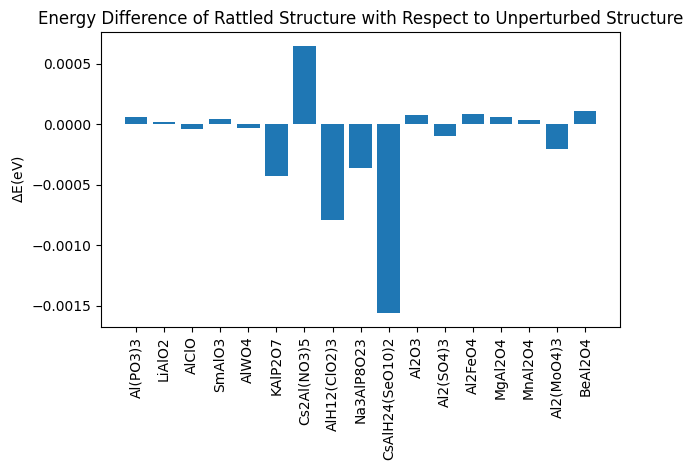

In [18]:
fig, ax = plt.subplots()
bars = ax.bar(compounds, delta_e)  # Assuming you have these lists already

# Add labels on top of each bar
ax.set_title("Energy Difference of Rattled Structure with Respect to Unperturbed Structure")
ax.set_ylabel("$\Delta$E(eV)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("../figures/energy_difference_plot.png", dpi=300, bbox_inches='tight')

plt.show()